The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Pré-treinamento do word2vec
:label:`sec_word2vec_pretraining`

Nesta seção, treinaremos um modelo skip-gram definido em
:numref:`sec_word2vec`.

Primeiro, importe os pacotes e módulos necessários para o experimento e carregue o conjunto de dados PTB.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

## O Modelo Skip-Gram

Implementaremos o modelo skip-gram usando camadas de incorporação e multiplicação de minibatch. Esses métodos também são frequentemente usados para implementar outros aplicativos de processamento de linguagem natural.

### Camada de incorporação

Conforme descrito em :numref:`sec_seq2seq`,
A camada na qual a palavra obtida é incorporada é chamada de camada de incorporação, que pode ser obtida criando uma instância `nn.Embedding` em APIs de alto nível. O peso da camada de incorporação é uma matriz cujo número de linhas é o tamanho do dicionário (`input_dim`) e cujo número de colunas é a dimensão de cada vetor de palavra (`output_dim`). Definimos o tamanho do dicionário como $20$ e a dimensão do vetor da palavra como $4$.


In [2]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype={embed.weight.dtype})


A entrada da camada de incorporação é o índice da palavra. Quando inserimos o índice $i$ de uma palavra, a camada de incorporação retorna a linha $i^\mathrm{th}$ da matriz de peso como seu vetor de palavra. Abaixo, inserimos um índice de forma ($2$, $3$) na camada de incorporação. Como a dimensão do vetor de palavras é 4, obtemos um vetor de palavras de forma ($2$, $3$, $4$).


In [3]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-1.1053,  0.1184,  0.0823, -0.2267],
         [ 2.4417, -1.0708,  0.1795, -0.3554],
         [ 0.3089, -0.4537,  1.1768,  1.3481]],

        [[-1.8293, -1.1143, -0.4053,  1.0142],
         [-0.4587, -0.8997,  1.1724, -0.9287],
         [-0.0265,  0.8163,  0.7636, -2.3677]]], grad_fn=<EmbeddingBackward>)

### Cálculo de avanço do modelo Skip-Gram

No cálculo progressivo, a entrada do modelo skip-gram contém o índice central da palavra-alvo `center` e o contexto concatenado e o índice da palavra de ruído `contexts_and_negatives`. Em que, a variável `center` tem a forma (tamanho do lote, 1), enquanto a variável `contexts_and_negatives` tem a forma (tamanho do lote, `max_len`). Essas duas variáveis são primeiro transformadas de índices de palavras em vetores de palavras pela camada de incorporação de palavras e, em seguida, a saída da forma (tamanho do lote, 1, `max_len`) é obtida pela multiplicação de minibatch. Cada elemento na saída é o produto interno do vetor de palavra de destino central e do vetor de palavra de contexto ou vetor de palavra de ruído.


In [4]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

Verifique se a forma de saída deve ser (tamanho do lote, 1, `max_len`).


In [5]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

## Treinamento

Antes de treinar o modelo de incorporação de palavras, precisamos definir a função de perda do modelo.

### Função de perda de entropia cruzada binária

De acordo com a definição da função de perda na amostragem negativa, podemos usar diretamente a função de perda de entropia cruzada binária de APIs de alto nível.


In [6]:
class SigmoidBCELoss(nn.Module):
    "BCEWithLogitLoss with masking on call."
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

Vale ressaltar que podemos usar a variável máscara para especificar o valor predito parcial e o rótulo que participam do cálculo da função de perda no minibatch: quando a máscara for 1, o valor predito e o rótulo da posição correspondente participarão do cálculo de a função de perda; Quando a máscara é 0, eles não participam. Como mencionamos anteriormente, as variáveis de máscara podem ser usadas para evitar o efeito do preenchimento nos cálculos da função de perda.

Dados dois exemplos idênticos, máscaras diferentes levam a valores de perda diferentes.


In [7]:
pred = torch.tensor([[.5]*4]*2)
label = torch.tensor([[1., 0., 1., 0.]]*2)
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask)

tensor([0.7241, 0.3620])

Podemos normalizar a perda em cada exemplo devido a vários comprimentos em cada exemplo.


In [8]:
loss(pred, label, mask) / mask.sum(axis=1) * mask.shape[1]

tensor([0.7241, 0.7241])

### Inicializando os parâmetros do modelo

Construímos as camadas de incorporação das palavras central e de contexto, respectivamente, e definimos a dimensão do vetor da palavra hiperparâmetro `embed_size` para 100.


In [9]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

### Treinamento

A função de treinamento é definida abaixo. Devido à existência de preenchimento, o cálculo da função de perda é ligeiramente diferente em comparação com as funções de treinamento anteriores.


In [10]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    metric = d2l.Accumulator(2)  # Sum of losses, no. of tokens
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

Now, we can train a skip-gram model using negative sampling.


loss 0.373, 368911.4 tokens/sec on cuda:0


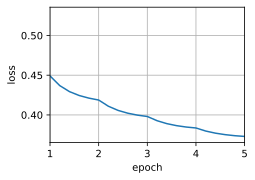

In [11]:
lr, num_epochs = 0.01, 5
train(net, data_iter, lr, num_epochs)

## Aplicando o modelo de incorporação de palavras

Depois de treinar o modelo de incorporação de palavras, podemos representar a similaridade no significado entre as palavras com base na similaridade do cosseno de dois vetores de palavras. Como podemos ver, ao usar o modelo de incorporação de palavras treinadas, as palavras com significado mais próximo da palavra "chip" estão principalmente relacionadas a chips.


In [12]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.idx_to_token[i]}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.513: microprocessor
cosine sim=0.493: intel
cosine sim=0.451: drives


## Sumário

* Podemos pré-treinar um modelo de grama de salto por meio de amostragem negativa.


## Exercícios

1. Defina `sparse_grad = True` ao criar uma instância de `nn.Embedding`. Acelera o treinamento? Consulte a documentação do MXNet para aprender o significado desse argumento.
1. Tente encontrar sinônimos para outras palavras.
1. Ajuste os hiperparâmetros e observe e analise os resultados experimentais.
1. Quando o conjunto de dados é grande, costumamos amostrar as palavras de contexto e as palavras de ruído para a palavra de destino central no minibatch atual apenas ao atualizar os parâmetros do modelo. Em outras palavras, a mesma palavra de destino central pode ter palavras de contexto ou palavras de ruído diferentes em épocas diferentes. Quais são os benefícios desse tipo de treinamento? Tente implementar este método de treinamento.


[Discussão](https://discuss.d2l.ai/t/1335)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTExNjg0MzM3NzVdfQ==
-->
